In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import njit, prange
from tqdm import trange, tqdm

In [ ]:
Lx = np.arange(2, 9, 1)
Kt = np.arange(1.0, 5.0, 0.1)
Ly = 4
J = 1

In [ ]:
@njit
def return_spins_with_bitmask(k: int, Lx: int, Ly: int) -> np.ndarray:
    """
    Функция для генерации конфигурации спинов с помощью преобразования некоторого
    целого числа x в массив состоящий из чисел -1 и 1.
    Данное преобразование проводится с помощью бинарной операции "побитовое и" &.
    Мы переберем все возможные конфигурации спинов для заданных размеров, учитывая что
    функция энергия четная.

    Параметры
    ----------
    k - число, из которого мы делаем массив.
    Lx - длина решетки по оси x.
    Ly - длина решетки по оси y.

    Возвращаемое значение
    ---------------------
    Массив размера спинов Lx * Ly спинов.
    """
    bit_mask = np.int64(k)
    spins = np.empty((Lx, Ly), dtype=np.int8)
    for i in range(Lx):
        for j in range(Ly):
            spins[i][j] = (bit_mask & 1) * 2 - 1
            bit_mask= bit_mask >> 1
    return spins


@njit(parallel = True)
def find_mean_energy(T: int, Lx: int, Ly: int) -> float:

    """
    Функция для расчета средней нормированной энергии при зафиксированном Lx и зафиксированной температуре T.

    Параментры
    ----------
    T - температура.
    Lx - Длина решетки по оси x.
    Ly - длина решетки по оси y.


    Возвращаемое значение
    ---------------------
    Возвращает значение нормированной энергии.
    """
    N = Lx * Ly
    Mean_Energy = 0
    Prob_Sum = 0
    for k in prange(2**N):
        Energy = 0
        spins = return_spins_with_bitmask(k, Lx, Ly)
        for x in range(-1, Lx - 1):
            for y in range(-1, Ly - 1):
                Energy -= spins[x, y] * (spins[x, y + 1] + spins[x + 1, y]) * J
        tmp_probability = np.exp(- Energy / T)
        Mean_Energy += Energy * tmp_probability
        Prob_Sum += tmp_probability
    Mean_Energy /= Prob_Sum * N
    return Mean_Energy


def Izing(Lx: int, Ly: int, Lx_index: int,  Temperature_array: np.array, Energy_array: np.array) -> None:

    """
    Функция для расчета средней нормированной энергии при зафиксированном Lx. Они записываются во внешнюю переменную Energy_array.

    Параментры
    ----------
    Temperature_array - массив температур.
    Lx_ - Массив возможных длин решеток по оси x.
    Ly - длина решетки по оси y.
    Energy_array - матрица нормированных энергий, куда мы записываем среднюю энергию.


    Возвращаемое значение
    ---------------------
    Не возвращает ничего.
    """

    start = time.time()
    for T_index in trange(len(Temperature_array)):
        T = Temperature_array[T_index]
        Energy_array[Lx_index, T_index] = find_mean_energy(T, Lx, Ly)
    end = time.time()
    print(end - start, 'секунд вычислялось при Lx =', Lx, ".")


def save_data(Energy_Array: np.array) -> None:
    """
    Функция для сохранения данных из матрицы нормированных энергий в массив.

    Параментры
    ----------
    Energy_Array - Массив нормированных энергий.

    Возвращаемое значение
    ---------------------
    Не возвращает ничего.

    """
    np.save('Energy_Array.npy', Energy_Array)


def show_plot(Lx_Array: np.array, Temperature_Array:np.array) -> None:
    """
    Функция для вывода графика по полученным заранее данным.

    Параментры
    ----------
    Temperature_Array - массив температур.
    Lx_Array - Массив возможных длин решеток по оси x.

    Возвращаемое значение
    ---------------------
    Не возвращает ничего.

    """
    Data = np.load("Energy_Array.npy")
    plt.figure(figsize=(10, 10))
    plt.pcolormesh(Lx_Array, Temperature_Array, Data.transpose(), cmap="inferno")
    plt.colorbar()
    plt.title('Карта нормированной средней энергии.')
    plt.xlabel("Lx")
    plt.ylabel("kT")
    plt.show()


def main_calculation(Lx_Array: np.array, Ly: int, Kt: np.array) -> None:
    """
    Функция для поэтапного выполнения всей лабороторной работы, а конкретно для:
    1) Cоздания массива для нормированных энергий.
    2) Проведение расчета для каждого Lx через функцию Izing.
    3) Записываем массив нормированных энергий в файл.
    4) Рисуем по этому файлу график.

    Параментры
    ----------
    Kt - массив температур.
    Lx_Array - Массив возможных длин решеток по оси x.
    Ly - длина решетки по оси y.

    Возвращаемое значение
    ---------------------
    Не возвращает ничего.
    """
    Energy_Array = np.zeros((len(Lx_Array), len(Kt)))
    for i in range(len(Lx_Array)):
        Izing(Lx[i], Ly, i, Kt, Energy_Array)
    save_data(Energy_Array)
    show_plot(Lx_Array, Kt)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 20.44it/s]


1.97332763671875 секунд вычислялось при Lx = 2 .


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 7998.67it/s]


0.008002281188964844 секунд вычислялось при Lx = 3 .


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 615.27it/s]


0.06801390647888184 секунд вычислялось при Lx = 4 .


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 50.95it/s]


0.7870199680328369 секунд вычислялось при Lx = 5 .


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:13<00:00,  2.91it/s]


13.735156059265137 секунд вычислялось при Lx = 6 .


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [04:01<00:00,  6.04s/it]


241.5053255558014 секунд вычислялось при Lx = 7 .


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [1:10:17<00:00, 105.44s/it]


4217.479179143906 секунд вычислялось при Lx = 8 .


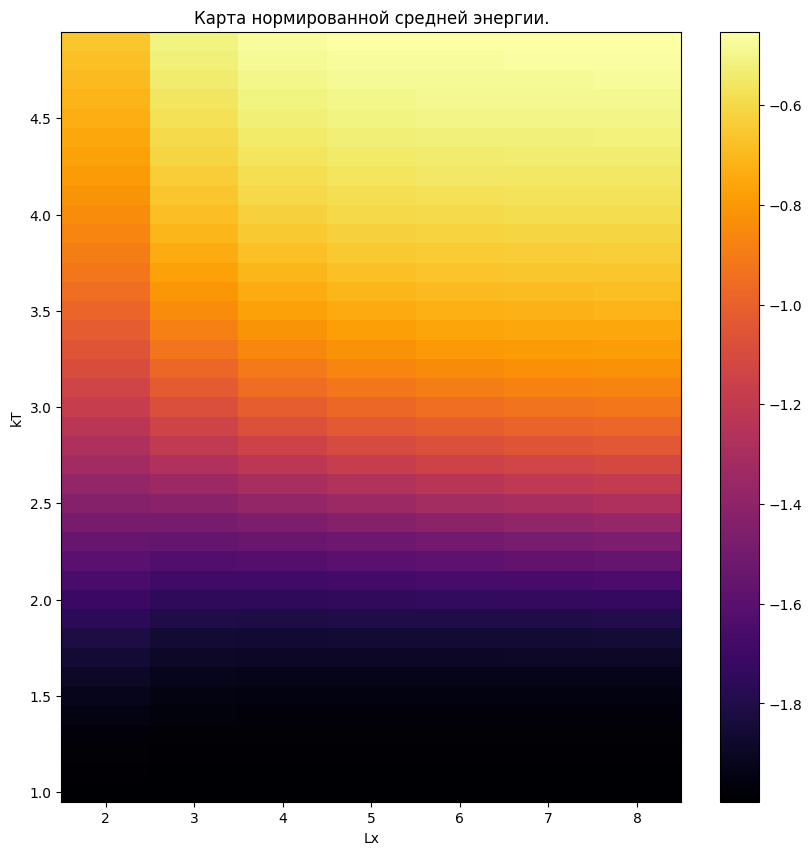

In [ ]:
main_calculation(Lx, Ly, Kt)